# PyRoot vs. Scipy Fitting 
### Author : Greg Furlich
### Data : 2019-03-13
### Purpose : Example of fitting in Python using PyRoot vs Scipy
More at [PyRoot vs. SciPy Fitting in Python](https://gregfurlich.com/posts/pyroot-vs-scipy.html)

In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import chi2
from ROOT import TCanvas, TGraph, TH1F, TF1, gStyle, TH1D
import ROOT as r
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/04


In [2]:
# Module Versions #

In [3]:
print('Scipy v'+sp.__version__,'Numpy v'+np.__version__)
!root --version

Scipy v1.1.0 Numpy v1.15.0
ROOT Version: 6.18/04
Built for linuxx8664gcc on Sep 24 2019, 21:30:00
From @


## Creating Python histogram

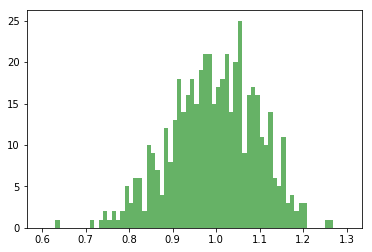

In [4]:
# Define Python Histogram #
mean, std = 1 , 0.1
data = sp.random.normal(mean,std,500)

# Define Bin Size #
xmin = np.floor(10.*data.min())/10.
xmax = np.ceil(10.*data.max())/10.
nbins = int((xmax-xmin)*100)
# print(xmin, xmax, nbins)

# Create Python Histogram
hist, bin_edges, patches = plt.hist(data,nbins,(xmin,xmax),color='g',alpha=0.6)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2.

# Find Non-zero bins in Histogram
nz = hist>0
first_nz = bin_centers[nz][ 0] - 0.005
last_nz  = bin_centers[nz][-1] + 0.005

## Load Histogram, Plot, and Fit in Pyroot

In [5]:
# Load Histogram and Plot in Pyroot #
plt.ion()
c1 = TCanvas()
gStyle.SetOptFit(111)

root_hist = np.zeros(nbins+2,dtype=float)
root_hist[1:-1] = hist
h = TH1D('h','hist',nbins,bin_edges)
h.SetContent(root_hist)
h.SetTitle("Root Histogram with Fit;X Axis;Y Axis [Counts]")
# Fit histogram with root
h.Fit('gaus','','',xmin,xmax)

# Get Root Fit and Goodness of Fit Parameters #
f = h.GetFunction('gaus')
const,mu,sigma = f.GetParameter(0), f.GetParameter(1), f.GetParameter(2)
econst,emu,esigma = f.GetParError(0), f.GetParError(1), f.GetParError(2)
ndf,chi2,prob = f.GetNDF(),f.GetChisquare(),f.GetProb()

print(chi2, ndf)
print(chi2/ndf,prob)

42.66631999946982 49
0.870741224478976 0.7262430108790452
 FCN=42.6663 FROM MIGRAD    STATUS=CONVERGED      61 CALLS          62 TOTAL
                     EDM=8.91288e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.85523e+01   1.13670e+00   2.79786e-03  -4.90752e-04
   2  Mean         1.00085e+00   4.94813e-03   1.59609e-05   1.07226e-01
   3  Sigma        1.00168e-01   4.41742e-03   3.62114e-05   5.30439e-02


## Draw Histogram with Pyroot

Info in <TCanvas::Print>: pdf file root_fit.pdf has been created


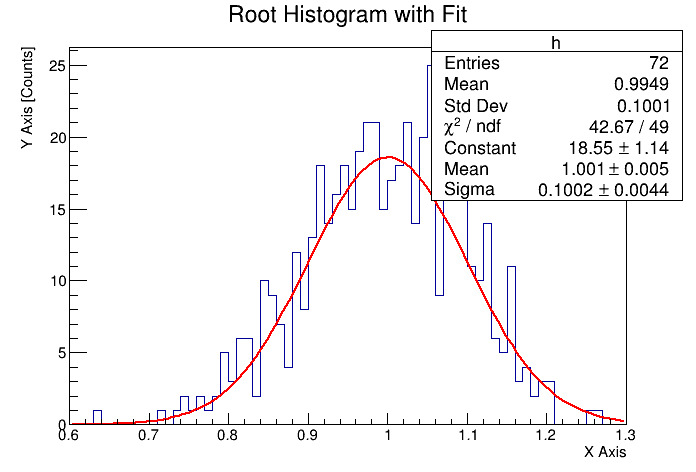

In [6]:
# Draw Fit and Histogram#
h.Draw()
c1.Draw()
c1.SaveAs('root_fit.pdf')

## Convert PDF to PNG ##
ROOT saves canvas as vectors (pdf or eps). Use Imagemagick to convert to png file.

In [7]:
!convert -density 300 root_fit.pdf -append -resize 1024x -quality 100  root_fit.png

## Scipy Fit

In [8]:
#Scipy Fit #

# Gaussian Fit Function :
def gaus(x, const, mu, sigma):
    return const* np.exp(-0.5*((x - mu)/sigma)**2)

# Define Range and Fit :
coeff, covar = curve_fit(gaus, bin_centers[nz], hist[nz])

## Calculate and Compare Fit Results #

In [14]:
# Define Fit Curves #
x = bin_centers
root_gaus = (const,mu,sigma)
opti_gaus = coeff

# Calculate chi Squared
f_root = gaus(x,*root_gaus)
f_opti = gaus(x,*opti_gaus)
ch2_root = np.sum( (hist[nz]-f_root[nz])**2/hist[nz])
ch2_opti = np.sum( (hist[nz]-f_opti[nz])**2/hist[nz])

# Calculate Degrees of Freedom with 3 fit parameters
dof = len(x[nz])-3

# Calculate Probablity #
p_root = sp.stats.chi2.sf(ch2_root, dof)
p_opti = sp.stats.chi2.sf(ch2_opti, dof)

print('Hist\tCalc Package\tChi Sq\t Chi2/dof\tprob')
print('Root\tRoot\t{0}\t{1}\t{2}'.format(chi2, chi2/dof, prob))
print('Root\tPython\t{0}\t{1}\t{2}'.format(ch2_root, ch2_root/dof, p_root))
print('Scipy\tPython\t{0}\t{1}\t{2}'.format(ch2_opti, ch2_opti/dof, p_opti))
print('Degrees of Freedom =\t{0}'.format(str(dof)))

Hist	Calc Package	Chi Sq	 Chi2/dof	prob
Root	Root	42.66631999946982	0.870741224478976	0.7262430108790452
Root	Python	42.666319999469835	0.8707412244789762	0.7262430108790432
Scipy	Python	47.91667350248406	0.9778912959690624	0.5170363527351618
Degrees of Freedom =	49


## Draw Histogram and Fits with Python Mathplotlib 

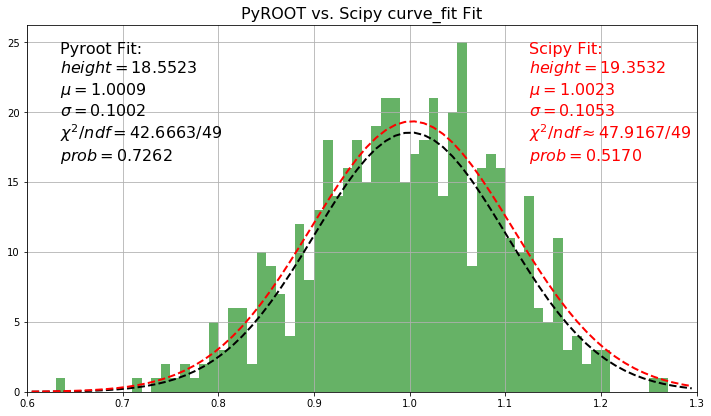

In [10]:
fig, ax = plt.subplots(figsize=(12,6.75))
plt.hist(data,nbins,(xmin,xmax),color='g',alpha=0.6)
plt.plot(bin_centers, f_root, 'k--', linewidth=2, label='ROOT')
plt.plot(bin_centers, f_opti, 'r--', linewidth=2, label='curve_fit')
plt.xlim(xmin, xmax)

# Plot Text Boxes #
root_txt = '\n'.join((
    r'Pyroot Fit:',
    r'$height={0:.4f}$'.format(const),
    r'$\mu={0:.4f}$'.format(mu),
    r'$\sigma={0:.4f}$'.format(sigma),
    r'$\chi^2 / ndf ={0:.4f} / {1}$'.format(ch2_root, ndf),
    r'$prob ={0:.4f}$'.format(p_root)))

scipy_txt = '\n'.join((
    r'Scipy Fit:',
    r'$height={0:.4f}$'.format(coeff[0]),
    r'$\mu={0:.4f}$'.format(coeff[1]),
    r'$\sigma={0:.4f}$'.format(np.abs(coeff[2])),
    r'$\chi^2 / ndf ={0:.4f} / {1}$'.format(ch2_opti, dof),
    r'$prob ={0:.4f}$'.format(p_opti)))

ax.text(0.05, 0.95, root_txt, transform=ax.transAxes, fontsize=16,
        verticalalignment='top')
ax.text(0.75, 0.95, scipy_txt, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', color='r')
plt.title('PyROOT vs. Scipy curve_fit Fit', fontsize=16)
# plt.grid()
plt.savefig('python_fit.png', dpi=300)